# CNN을 통한 다중 이미지 학습

## Google Colab 링크

https://colab.research.google.com/drive/1GcJCFBzVJS-zfe-3XAdXauxXtVHPsdmQ#scrollTo=7QQOaOx2ISqq

**학습 데이터세트는 AI Hub에서 신청하여 받았고, 저작자는 한국지능정보사회진흥원이다.**

## 참고자료

https://lsjsj92.tistory.com/387

In [ ]:
# Google Colab 재시작
!kill -9 -1

## 데이터세트 다운로드

구글 드라이브에 업로드한 zip 파일을 File ID로 다운받고 압축을 해제한다.

In [1]:
!gdown --id 1AeNCnN8nOQI2q3p7kpeht2y6Aa95eHmT --output other_food.zip

Downloading...
From: https://drive.google.com/uc?id=1AeNCnN8nOQI2q3p7kpeht2y6Aa95eHmT
To: /content/other_food.zip
348MB [00:02, 164MB/s]


In [2]:
!gdown --id 1WWP5_j1QXTKPYyREPuT7-d7IQdGgldgB --output img_test.zip

Downloading...
From: https://drive.google.com/uc?id=1WWP5_j1QXTKPYyREPuT7-d7IQdGgldgB
To: /content/img_test.zip
100% 1.90M/1.90M [00:00<00:00, 60.1MB/s]


`other_food`는 훈련 데이터, `img_test`는 검증 데이터다.

In [ ]:
!unzip other_food.zip

In [ ]:
!unzip img_test.zip

경로를 지정하고 데이터세트 이미지 개수를 확인한다.

In [5]:
import pathlib
img_dir = 'other_food'
data_dir = pathlib.Path(img_dir)

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2903


## 멀티라벨 분류

데이터세트를 `콩자반`, `피자`, `후라이드치킨` 3가지로 분류한다.

In [7]:
from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split

In [8]:
caltech_dir = "other_food"
categories = ['beans', 'pizzas', 'fried_chickens']
nb_classes = len(categories)

image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
y = []

for idx, food in enumerate(categories):
    
    #one-hot 돌리기.
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    image_dir = caltech_dir + "/" + food
    files = glob.glob(image_dir+"/*.jpg")
    print(food, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X.append(data)
        y.append(label)

        if i % 700 == 0:
            print(food, " : ", f)

beans  파일 길이 :  977
beans  :  other_food/beans/Img_025_0457.jpg
beans  :  other_food/beans/Img_025_0839.jpg
pizzas  파일 길이 :  944
pizzas  :  other_food/pizzas/Img_027_0341.jpg


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


pizzas  :  other_food/pizzas/Img_027_0799.jpg
fried_chickens  파일 길이 :  982
fried_chickens  :  other_food/fried_chickens/Img_028_0861.jpg
fried_chickens  :  other_food/fried_chickens/Img_028_0607.jpg


In [9]:
!mkdir numpy_data

In [10]:
X = np.array(X)
y = np.array(y)
#1 0 0 0 이면 airplanes
#0 1 0 0 이면 buddha 이런식


X_train, X_test, y_train, y_test = train_test_split(X, y)
xy = (X_train, X_test, y_train, y_test)
np.save("numpy_data/multi_image_data.npy", xy)

print("ok", len(y))

ok 2903


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


## 모델 훈련

이제 numpy 데이터를 불러와 훈련을 시작한다.

In [12]:
import os, glob, numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf

In [16]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

X_train, X_test, y_train, y_test = np.load('numpy_data/multi_image_data.npy', allow_pickle=True)
print(X_train.shape)
print(X_train.shape[0])

(2177, 64, 64, 3)
2177


In [43]:
categories = ['beans', 'pizzas', 'fried_chickens']
nb_classes = len(categories)

#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

In [44]:
!mkdir model

mkdir: cannot create directory ‘model’: File exists


In [45]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
    
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_dir = 'model'
    
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    
model_path = model_dir + '/multi_img_classification.model'
checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=6)

In [46]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 16384)            

In [47]:
#데이터셋이 적어서 validation을 그냥 test 데이터로 했습니다. 
#데이터셋이 충분하시면 이렇게 하시지 마시고 validation_split=0.2 이렇게 하셔서 테스트 셋으로 나누시길 권장합니다.
# history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.2, callbacks=[checkpoint, early_stopping])

Epoch 1/50
55/55 [==============================] - 14s 241ms/step - loss: 1.0980 - accuracy: 0.3511 - val_loss: 1.0485 - val_accuracy: 0.6193

Epoch 00001: val_loss improved from inf to 1.04849, saving model to model/multi_img_classification.model
INFO:tensorflow:Assets written to: model/multi_img_classification.model/assets
Epoch 2/50
55/55 [==============================] - 13s 237ms/step - loss: 0.9902 - accuracy: 0.5045 - val_loss: 0.7481 - val_accuracy: 0.6560

Epoch 00002: val_loss improved from 1.04849 to 0.74813, saving model to model/multi_img_classification.model
INFO:tensorflow:Assets written to: model/multi_img_classification.model/assets
Epoch 3/50
55/55 [==============================] - 13s 235ms/step - loss: 0.7350 - accuracy: 0.6416 - val_loss: 0.6287 - val_accuracy: 0.7500

Epoch 00003: val_loss improved from 0.74813 to 0.62869, saving model to model/multi_img_classification.model
INFO:tensorflow:Assets written to: model/multi_img_classification.model/assets
Epoch 4/

In [49]:
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

23/23 [==============================] - 1s 60ms/step - loss: 0.3751 - accuracy: 0.8650
정확도 : 0.8650


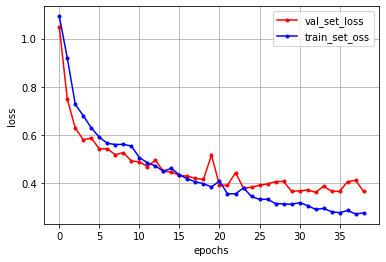

In [50]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

## 모델 정확성 검증

In [51]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model

In [52]:
caltech_dir = "img_test"
image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
filenames = []
files = glob.glob(caltech_dir+"/*.*")
for i, f in enumerate(files):
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    data = np.asarray(img)
    filenames.append(f)
    X.append(data)

X = np.array(X)
model = load_model('model/multi_img_classification.model')

prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0

#이 비교는 그냥 파일들이 있으면 해당 파일과 비교. 카테고리와 함께 비교해서 진행하는 것은 _4 파일.
for i in prediction:
    pre_ans = i.argmax()  # 예측 레이블
    print(i)
    print(pre_ans)
    pre_ans_str = ''
    if pre_ans == 0: pre_ans_str = "콩자반"
    elif pre_ans == 1: pre_ans_str = "피자"
    else: pre_ans_str = "후라이드치킨"
    if i[0] >= 0.8 : print("해당 "+filenames[cnt].split("/")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[1] >= 0.8: print("해당 "+filenames[cnt].split("/")[1]+"이미지는 "+pre_ans_str+"으로 추정됩니다.")
    if i[2] >= 0.8: print("해당 "+filenames[cnt].split("/")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    cnt += 1
    # print(i.argmax()) #얘가 레이블 [1. 0. 0.] 이런식으로 되어 있는 것을 숫자로 바꿔주는 것.
    # 즉 얘랑, 나중에 카테고리 데이터 불러와서 카테고리랑 비교를 해서 같으면 맞는거고, 아니면 틀린거로 취급하면 된다.
    # 이걸 한 것은 _4.py에.

[1.000 0.000 0.000]
0
해당 Img_027_0083.jpg이미지는 콩자반로 추정됩니다.
[1.000 0.000 0.000]
0
해당 Img_027_0092.jpg이미지는 콩자반로 추정됩니다.
[1.000 0.000 0.000]
0
해당 Img_028_0085.jpg이미지는 콩자반로 추정됩니다.
[1.000 0.000 0.000]
0
해당 Img_027_0089.jpg이미지는 콩자반로 추정됩니다.
[1.000 0.000 0.000]
0
해당 Img_025_0000.jpg이미지는 콩자반로 추정됩니다.
[1.000 0.000 0.000]
0
해당 Img_028_0076.jpg이미지는 콩자반로 추정됩니다.
[1.000 0.000 0.000]
0
해당 Img_025_0011.jpg이미지는 콩자반로 추정됩니다.
[1.000 0.000 0.000]
0
해당 Img_028_0081.jpg이미지는 콩자반로 추정됩니다.
[1.000 0.000 0.000]
0
해당 Img_025_0017.png이미지는 콩자반로 추정됩니다.
